In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import csv
import io
import pandas as pd
from scipy import interpolate
import scipy.optimize as opt
from scipy.interpolate import UnivariateSpline
   
from __future__ import print_function 
from scipy.optimize import curve_fit 

#change this to your nextcloud path
nextcloud_path = r"C:\Users\torre"

In [2]:
#Functions used later
def moku_read_specB(file_path):
    df = pd.read_csv(file_path,header=9)
    #print(df.to_string()) 
    x_data = df['% Frequency (Hz)']
    y_data1 = df[' Input A (V/rtHz)']
    #y_data1 =df[' Input B (V/rtHz)']
    
    return x_data, y_data1#, y_data2
def moku_read_specA(file_path):
    df = pd.read_csv(file_path,header=8)
    #print(df.to_string()) 
    x_data = df['% Frequency (Hz)']
    y_data1 = df[' Input A (V/rtHz)']
    #y_data1 =df[' Input B (V/rtHz)']
    
    return x_data, y_data1#, y_data2
#TF done on channel A
def moku_read_TF_A(file_path):
    df = pd.read_csv(file_path,header=7)
    #print(df.to_string()) 
    x_data = df['% Frequency (Hz)']
    y_data1 = df[' Math (Ch A / Ch B) Magnitude (dB)']
    y_data2 =df[' Math (Ch A / Ch B) Phase (deg)']
    	 	
    return x_data, y_data1, y_data2

#TF done on channel B
def moku_read_TF_B(file_path):
    df = pd.read_csv(file_path,header=7)
    #print(df.to_string()) 
    x_data = df['% Frequency (Hz)']
    y_data1 = df[' Channel B Magnitude (dB)']
    y_data2 =df[' Channel B Phase (deg)']
    	 	
    return x_data, y_data1, y_data2

def moku_read_TF_CH4(file_path):
    df = pd.read_csv(file_path,header=9)
    #print(df.to_string()) 
    x_data = df['% Frequency (Hz)']
    y_data1 = df[' Channel 4 Magnitude (dB)']
    y_data2 =df[' Channel 4 Phase (deg)']
    	 	
    return x_data, y_data1, y_data2

def moku_read_Probe_Points(file_path):
    df = pd.read_csv(file_path,header=14)
    #print(df.to_string()) 
    x_data = df['% Time (s)']
    y_data1 = df[' Probe A (Probe A) (V)']
    y_data2 =df[' Probe B (Probe B) (V)']
    	 	
    return x_data,y_data1,y_data2

def db2mag(db):
    return 10**(db/20)

def mag2db(mag):
    return 20*np.log10(mag)

def remove_nan_rows(array):
    # Find indices of NaN values in the array

    nan_indices = pd.isnull(array)

    # Remove rows with NaN values
    array_without_nan = array[~nan_indices]
    print(nan_indices)
    # Return new array
    return array_without_nan

def interpt1d(data):
    x_data = data[0]
    y_data = data[1]
    
    new_func = interpolate.interp1d(x_data, y_data)
    return new_func

def interpt1d_phase(data):
    x_data = data[0]
    y_data = data[2]
    
    new_func = interpolate.interp1d(x_data, y_data)
    return new_func

def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))

def linear_windowing(array1, array2, start_index, end_index):
    # Check if the specified range is valid
    if start_index < 0 or end_index >= min(len(array1), len(array2)) or start_index >= end_index:
        raise ValueError("Invalid range specified")
    array1 = np.abs(array1)
    array2 = np.abs(array2)
    
    # Calculate the window size and create the linear windowing function
    window_size = end_index - start_index+1
    window = np.linspace(0, 1, window_size)
    # Create new arrays to store the modified values
    modified_array1 = np.copy(array1)
    modified_array2 = np.copy(array2)

    # Apply the linear windowing function to both new arrays
    modified_array1[start_index:end_index+1] = array1[start_index:end_index+1] * (1-window)
    modified_array2[start_index:end_index+1] = array2[start_index:end_index+1]*window 

    
    #hybrid = np.concatenate((array1[:start_index],modified_array1[start_index:end_index]+modified_array2[start_index:end_index],array2[end_index:]))
    hybrid = np.abs(modified_array1) + np.abs(modified_array2)

    return modified_array1,modified_array2,hybrid

def linear_windowing_phase(array1, array2, start_index, end_index):
    # Check if the specified range is valid
    if start_index < 0 or end_index >= min(len(array1), len(array2)) or start_index >= end_index:
        raise ValueError("Invalid range specified")

    # Calculate the window size and create the linear windowing function
    window_size = end_index - start_index+1
    window = np.linspace(0, 1, window_size)
    # Create new arrays to store the modified values
    modified_array1 = np.copy(array1)
    modified_array2 = np.copy(array2)

    # Apply the linear windowing function to both new arrays
    modified_array1[start_index:end_index+1] = array1[start_index:end_index+1] * (1-window)
    modified_array2[start_index:end_index+1] = array2[start_index:end_index+1]*window 

    
    #hybrid = np.concatenate((array1[:start_index],modified_array1[start_index:end_index]+modified_array2[start_index:end_index],array2[end_index:]))
    hybrid = modified_array1 + modified_array2

    return modified_array1,modified_array2,hybrid,array1,array2

def lowpass(order,ugf,pass_band_db,freqs,**kwargs):
    order = order
    ugf = ugf
    pass_band_db = pass_band_db
    gain = 10**(pass_band_db/20)
    wc = (ugf/(gain+1))
    print("Cutoff Frequency for Fast Controller:",wc)

    new_freqs = freqs

    b, a = signal.butter(order, wc, 'low', analog=True)
    w, h1 = signal.freqs(b, a,worN=new_freqs)
    
    
    h1_dB = pass_band_db + 20 * np.log10(abs(h1))
    
    return w, h1_dB, 10**(h1/20.)
def find_FWHM(cavscan,scan_amp):
    
    peak = max(cavscan[1])
    index_max = np.argmax(cavscan[1])

    x_start = index_max - 25
    x_end = index_max + 25

    y_offset = np.average(cavscan[1])

    xdata = cavscan[0][x_start:x_end]
    ydata = cavscan[1][x_start:x_end]
    
    def lorentzian(x, amplitude, center, width):
        return amplitude / (1 + ((x - center) / (width/2))**2) + y_offset
    
    def Gauss(x, A, B): 
        y = A*np.exp(-1*B*(x-xdata[index_max])**2) + y_offset
        return y 
    initial_guess = [peak-y_offset, xdata[index_max], cavscan[0][x_end]-cavscan[0][x_start]]  # Initial guess for amplitude, center, and width
    params, covariance = curve_fit(lorentzian, xdata, ydata, p0=initial_guess)
    #parameters, covariance = curve_fit(lorentzian, xdata, ydata) 
    
    fit_A = params[0] 
    fit_B = params[1] 
    fit_C = params[2]

    finer_time = np.arange(cavscan[0][x_start],cavscan[0][x_end],.00001)

    fit_y = lorentzian(xdata, fit_A, fit_B,fit_C) 
    fit_y_fine = lorentzian(finer_time,fit_A,fit_B,fit_C)
    half_max_gauss = max(fit_y_fine-y_offset)/2

    
    spline = UnivariateSpline(finer_time, fit_y_fine-half_max_gauss-y_offset, s=0)
    r1, r2 = spline.roots() # find the roots

    FWHM = abs(r2-r1)

    #plt.plot(cavscan[0][x_start:x_end],cavscan[1][x_start:x_end]*1000,label = 'TRANS')
    #plt.ylabel('Amplitude (mV)')
    #plt.xlabel('Time (s)')
    #plt.xlim(0,.01)
    #plt.legend()
    # plt.title('Calculating FWHM via cavity scan; measured on TRANS PD')
    # plt.plot(xdata, ydata, 'o', label='data') 
    # plt.plot(xdata, fit_y, '-') 
    # plt.plot(finer_time,fit_y_fine,label='fit')
    # plt.axvspan(r1, r2, facecolor='g', alpha=0.5)
    # plt.legend()

    print("FWHM",FWHM)

    #convert FWHM in time to voltage to current to meters to frequency
    scan_freq = 10
    scan_amp = scan_amp
    miliamp_per_V = 2e-3
    meters_per_miliamp = 2.0198e-10 #experimentally determined from FSR measurement
    cav_len = 2.4
    lambda_1 = 1550e-9
    c = 3e8

    FWHM_in_volts = FWHM * (2*scan_amp/(1/scan_freq))


    BW = (FWHM_in_volts*(miliamp_per_V)*(meters_per_miliamp)*(c/lambda_1**2))
    BW_in_meters = FWHM_in_volts*(miliamp_per_V)*(meters_per_miliamp)*(cav_len/lambda_1)
    print("BW is:",BW)
    FSR = 125e6
    finesse = FSR/BW
    print("Finesse is:",finesse)

    error_max = max(cavscan[2])
    error_min = min(cavscan[2])
    error_amp = error_max-error_min

    # plt.figure(2)
    # plt.title("Cavity Error Signal for Amplitude Calculation")
    # plt.ylabel('Amplitude (mV)')
    # plt.xlabel('Time (s)')
    # plt.plot(cavscan[0][x_start:x_end],cavscan[2][x_start:x_end]*1000,label = 'error signal')
    # plt.axvspan(r1, r2, facecolor='g', alpha=0.5)
    # plt.show()
    
    return FWHM,BW,finesse,error_amp,BW_in_meters


#imports the TF for the high voltage amplifier
HV_amp_TF = moku_read_TF_CH4(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\HV_amplifier_TF.csv")
HV_amp_inter = interpolate.interp1d(HV_amp_TF[0],db2mag(HV_amp_TF[1])*np.exp(1j*HV_amp_TF[2]*np.pi/180))

In [3]:
#Jeff's controller functions
import control as ct
def PIS_controller(prop_gain_dB,int_crossover,int_saturation_dB):
    int_saturation_mag = 10**(int_saturation_dB/20)
    prop_gain_mag = 10**(prop_gain_dB/20)
    return ct.tf([1,int_crossover],[1/prop_gain_mag,int_crossover/int_saturation_mag])
def IS_controller(int_ugf,int_saturation_dB):
   int_saturation_mag = 10**(int_saturation_dB/20)
   return ct.tf([int_ugf],[1,-int_ugf/int_saturation_mag])

In [4]:
# Calibration and hybridization functions.

def hybrid(G,prop,ugf,pass_band_db,HV):
    #hybrid for data with piezo
    fast_freqs = np.arange(1,100000)
    if HV:
        HV_gain = 1 
    else:
        HV_amp_inter = interpolate.interp1d(HV_amp_TF[0],db2mag(HV_amp_TF[1])*np.exp(1j*HV_amp_TF[2]*np.pi/180))
        HV_gain = HV_amp_inter(fast_freqs)          
        
    G_inter = interpolate.interp1d(G[0],db2mag(G[1])*np.exp(1j*G[2]*np.pi/180.))
    
    h1_fast = PIS_controller(prop,ugf,pass_band_db)
    mag_fast,phase_fast,freq_fast = ct.bode(h1_fast,omega = fast_freqs ,Hz=True,dB=False,plot=False)
    
    #controller_inter = interpolate.interp1d(freq_fast,mag_fast*np.exp(1j*phase_fast)
    
    mag_fast = np.abs(mag_fast*np.exp(1j*phase_fast)/HV_gain)
    phase_fast = np.angle(mag_fast*np.exp(1j*phase_fast)/HV_gain)
    
    fast_controller_inter = interpolate.interp1d(freq_fast,mag_fast)
    fast_controller_phase_inter = interpolate.interp1d(freq_fast,phase_fast)
    
    low_freqs = np.arange(1,10000,1)
    new_freqs = np.arange(1000,50001,1)

    # Create window for hybrid
    f1 = low_freqs[0]
    f2 = low_freqs[-1]
    f3 = new_freqs[0]
    f4 = new_freqs[-1]

    G_zeroes = np.array([0.]*(f3-f1))
    h2_zeroes = np.array([0.]*(f4-f2))

    freqs_cat = np.arange(f1,f4+1)

    window_start = list(freqs_cat).index(np.round((f3)))#(f2-f3)/2+f3
    window_end = list(freqs_cat).index(f2)

    G_new = np.concatenate((G_zeroes,np.abs(G_inter(new_freqs))))
    h2_new = np.concatenate((fast_controller_inter(low_freqs),h2_zeroes)) #*1000 for the 60 db offset
    
    G_new_phase = np.concatenate((G_zeroes,np.angle(G_inter(new_freqs)*180/np.pi,deg=True)))
    h2_new_phase = np.concatenate((fast_controller_phase_inter(low_freqs)*180/np.pi,h2_zeroes))

    #Call hybrid function
    hybrid = linear_windowing(h2_new,G_new,window_start,window_end)
    hybrid_phase = linear_windowing_phase(h2_new_phase,G_new_phase,window_start,window_end)
    G_hybrid_complex = hybrid[2]*np.exp(1j*hybrid_phase[2]*np.pi/180)
    #Plots for sanity check if needed.
    plt.loglog(freqs_cat,np.abs(G_hybrid_complex),label = 'hybrid')
    # plt.title('unwindowed functions + hybrid')
    # plt.loglog(new_freqs,np.abs(G),label = 'G')
    plt.loglog(freqs_cat,h2_new,label = 'modelled fast controller')
    plt.loglog(new_freqs,np.abs(G_inter(new_freqs)),label = 'G')
    plt.axvspan(freqs_cat[window_start], f2, facecolor='g', alpha=0.2,label = 'hybridization window')
    #plt.ylim(1e-2,50)
    #plt.xlim(1e2,1e4)
    plt.legend()

    return freqs_cat,G_hybrid_complex

def hybrid_laser(G,ugf,pass_band_db):
    low_freqs = np.arange(1,10000,1)
    new_freqs = np.arange(1000,50001,1)
    
    G_inter = interpolate.interp1d(G[0],db2mag(G[1])*np.exp(1j*G[2]*np.pi/180.))
    h1_fast = IS_controller(42000,pass_band_db) #use new UGF to correct for gain of controller matching with G to use in approximation
    mag_fast,phase_fast,freq_fast = ct.bode(h1_fast,omega = low_freqs,Hz = True,plot = False)
    
    fast_controller_inter = interpolate.interp1d(low_freqs,mag_fast)
    fast_controller_phase_inter = interpolate.interp1d(low_freqs,phase_fast)


    # Create window for hybrid
    f1 = low_freqs[0]
    f2 = low_freqs[-1]
    f3 = new_freqs[0]
    f4 = new_freqs[-1]

    G_zeroes = np.array([0.]*(f3-f1))
    h2_zeroes = np.array([0.]*(f4-f2))

    freqs_cat = np.arange(f1,f4+1)

    window_start = list(freqs_cat).index(np.round((f3)))#(f2-f3)/2+f3
    window_end = list(freqs_cat).index(f2)

    G_new = np.concatenate((G_zeroes,np.abs(G_inter(new_freqs))))
    h2_new = np.concatenate((fast_controller_inter(low_freqs),h2_zeroes)) #*1000 for the 60 db offset
    
    G_new_phase = np.concatenate((G_zeroes,np.angle(G_inter(new_freqs)*180/np.pi,deg=True)))
    h2_new_phase = np.concatenate((fast_controller_phase_inter(low_freqs)*180/np.pi,h2_zeroes))

    #Call hybrid function
    hybrid = linear_windowing(h2_new,G_new,window_start,window_end)
    hybrid_phase = linear_windowing_phase(h2_new_phase,G_new_phase,window_start,window_end)
    G_hybrid_complex = hybrid[2]*np.exp(1j*hybrid_phase[2]*np.pi/180)
    
    #Plots for sanity check if needed.
    plt.figure(1)
    plt.loglog(freqs_cat,np.abs(G_hybrid_complex),label = 'hybrid')
    # plt.title('unwindowed functions + hybrid')
    # plt.loglog(new_freqs,np.abs(G),label = 'G')
    plt.loglog(freqs_cat,h2_new,label = 'modelled fast controller')
    plt.loglog(new_freqs,np.abs(G_inter(new_freqs)),label = 'G')
    plt.axvspan(freqs_cat[window_start], f2, facecolor='g', alpha=0.2,label = 'hybridization window')
    #plt.ylim(1e-2,50)
    #plt.xlim(1e2,1e5)
    plt.legend()
    # print('test')
    
    return freqs_cat,G_hybrid_complex

def calibrate_piezo(prop,ugf,pass_band_db,scan,scan_amp,scan_freq,speclow,spechigh,G,HV=True):
    
    hybrid_freqs,G_hybrid_complex = hybrid(G,prop,ugf,pass_band_db,HV)
    
    h1_fast = PIS_controller(prop,ugf,pass_band_db)
    mag_fast,phase_fast,freq_fast = ct.bode(h1_fast,omega = np.arange(1,100000),Hz=True,dB=False,plot=False)

    FWHM,BW,finesse,error_amp,BW_in_meters = find_FWHM(scan,scan_amp) #this "BW_in_meters" does not apply, just using find_FWHM function to find the FWHM.Actual BW_in_meters is calculated using the piezo respopnse below
    FWHM_in_volts = FWHM * (2*scan_amp/(1/scan_freq))
    
    #If you bypass the HV there is no *14.6 in the calibration to meters. This is measured in a TF across the HV amp directly.
    if HV:
        HV_gain = db2mag(23.3) #flat value and not TF because the scan is done at a constant frequency in the passband?
    else:
        HV_gain = db2mag(23.3)
        
    BW_in_meters = FWHM_in_volts * HV_gain * 3.3e-6/150

    fast_controller_inter = interpolate.interp1d(freq_fast,mag_fast*np.exp(1j*phase_fast))
    spec_high_freq_inter = interpolate.interp1d(spechigh[0],spechigh[1])
    spec_low_freq_inter = interpolate.interp1d(speclow[0],speclow[1])
    G_inter = interpolate.interp1d(hybrid_freqs,G_hybrid_complex)   #(G[0],db2mag(G[1])*np.exp(1j*G[2]*np.pi/180.))

    new_freqs_high = np.arange(max(min(G[0]),min(spechigh[0])),np.floor(min(max(G[0]),max(spechigh[0]))))
    new_freqs_low = np.arange(max(min(G[0]),min(speclow[0])),np.floor(min(max(G[0]),max(speclow[0]))))

    #calibrated_spectrum_high = np.sqrt(spec_high_freq_inter(new_freqs_high)**2/np.abs(1/(1-G_inter(new_freqs_high)))**2/np.abs(fast_controller_inter(new_freqs_high))**2*(BW_in_meters/error_amp)**2)
    #calibrated_spectrum_low = np.sqrt(spec_low_freq_inter(new_freqs_low)**2/np.abs(1/(1-G_inter(new_freqs_low)))**2/np.abs(fast_controller_inter(new_freqs_low))**2*(BW_in_meters/error_amp)**2)
    new_cal = np.average(np.array([4.084758487485128e-07,1.0533423376692312e-07,9.03732792028233e-08]))
    calibrated_spectrum_high = spec_high_freq_inter(new_freqs_high)/np.abs(1/(1-G_inter(new_freqs_high)))/np.abs(fast_controller_inter(new_freqs_high))*new_cal#*(BW_in_meters/error_amp)
    calibrated_spectrum_low = spec_low_freq_inter(new_freqs_low)/np.abs(1/(1-G_inter(new_freqs_low)))/np.abs(fast_controller_inter(new_freqs_low))*new_cal#*(BW_in_meters/error_amp)
    
    spectrum_no_CLG_high = spec_high_freq_inter(new_freqs_high)/np.abs(fast_controller_inter(new_freqs_high))*new_cal#*(BW_in_meters/error_amp)
    spectrum_no_CLG_low = spec_low_freq_inter(new_freqs_low)/np.abs(fast_controller_inter(new_freqs_low))*new_cal#*(BW_in_meters/error_amp)
    
    return new_freqs_low,calibrated_spectrum_low,new_freqs_high,calibrated_spectrum_high,hybrid_freqs,G_inter(hybrid_freqs),spectrum_no_CLG_low,spectrum_no_CLG_high,BW_in_meters/error_amp

def calibrate_laser(order,ugf,pass_band_db,scan,scan_amp,speclow,spechigh,G):
                                                
    hybrid_freqs,G_hybrid_complex = hybrid_laser(G,ugf,pass_band_db)
    lowpass_freqs,h1_db_laser,h1_laser = lowpass(order,ugf,pass_band_db,np.arange(1,1e6))


    FWHM_laser,BW,finesse_laser,error_amp_laser,BW_in_meters_laser = find_FWHM(scan,scan_amp)

    fast_controller_laser_inter = interpolate.interp1d(lowpass_freqs,db2mag(h1_db_laser))
    laser_spec_high_freq_inter = interpolate.interp1d(spechigh[0],spechigh[1])
    laser_spec_low_freq_inter = interpolate.interp1d(speclow[0],speclow[1])
    
    G_laser_inter = interpolate.interp1d(hybrid_freqs,G_hybrid_complex)
    
    new_freqs_high = np.arange(max(min(G[0]),min(spechigh[0])),np.floor(min(max(G[0]),max(spechigh[0]))))
    new_freqs_low = np.arange(max(min(G[0]),min(speclow[0])),np.floor(min(max(G[0]),max(speclow[0]))))

    #calibrated_spectrum_high = np.sqrt(laser_spec_high_freq_inter(new_freqs_high)**2/np.abs(1/(1-G_laser_inter(new_freqs_high)))**2/fast_controller_laser_inter(new_freqs_high)**2*(BW_in_meters_laser/error_amp_laser)**2)
    #calibrated_spectrum_low = np.sqrt(laser_spec_low_freq_inter(new_freqs_low)**2/np.abs(1/(1-G_laser_inter(new_freqs_low)))**2/fast_controller_laser_inter(new_freqs_low)**2*(BW_in_meters_laser/error_amp_laser)**2)
    new_cal = np.average(np.array([4.084758487485128e-07,1.0533423376692312e-07,9.03732792028233e-08]))
    calibrated_spectrum_high = laser_spec_high_freq_inter(new_freqs_high)/np.abs(1/(1-G_laser_inter(new_freqs_high)))/fast_controller_laser_inter(new_freqs_high)*new_cal#*(BW_in_meters_laser/error_amp_laser)
    calibrated_spectrum_low = laser_spec_low_freq_inter(new_freqs_low)/np.abs(1/(1-G_laser_inter(new_freqs_low)))/fast_controller_laser_inter(new_freqs_low)*new_cal#*(BW_in_meters_laser/error_amp_laser)
    
    spectrum_no_CLG_high = laser_spec_high_freq_inter(new_freqs_high)/fast_controller_laser_inter(new_freqs_high)*new_cal#*(BW_in_meters_laser/error_amp_laser)
    spectrum_no_CLG_low = laser_spec_low_freq_inter(new_freqs_low)/fast_controller_laser_inter(new_freqs_low)*new_cal#*(BW_in_meters_laser/error_amp_laser)
    
    return new_freqs_low,calibrated_spectrum_low,new_freqs_high,calibrated_spectrum_high,hybrid_freqs,G_hybrid_complex,spectrum_no_CLG_low,spectrum_no_CLG_high,BW_in_meters_laser/error_amp_laser

# Compare Piezo lock vs laser lock

FWHM 0.00019083838263869723
BW is: 106852.55910881361
Finesse is: 1169.8362776010435


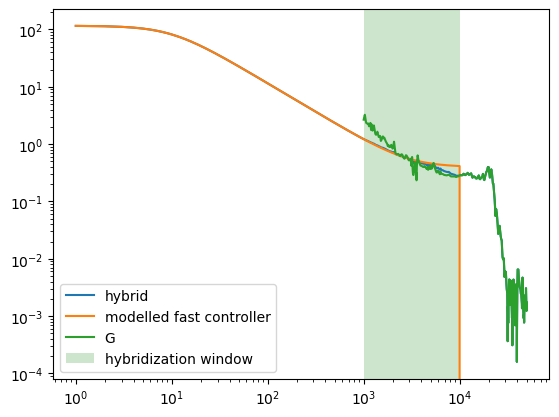

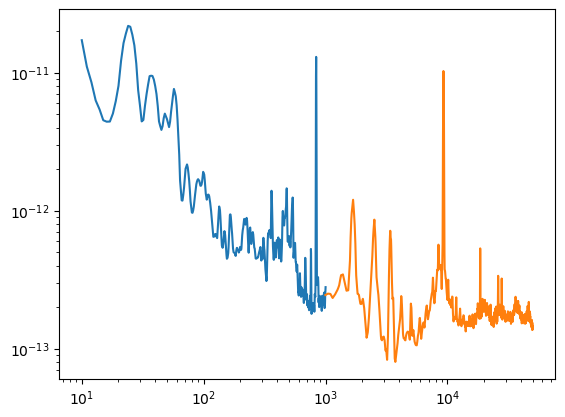

1.807465584056466e-07


In [5]:
piezo_spec_low_freq_HV= moku_read_specB(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\piezoHVlock\piezoHVSpec_lowfreq_20240422_113006_Traces.csv")
piezo_spec_high_freq_HV = moku_read_specB(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\piezoHVlock\piezoHVSpec_highfreq_20240422_112917_Traces.csv")
piezo_scan_HV = moku_read_Probe_Points(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\piezoHVlock\piezoHV_scan_20240422_112400_Traces.csv")
G_piezo_HV = moku_read_TF_B(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\piezoHVlock\piezoHV_G_20240422_112828_Traces.csv")

scan_amp_piezo_HV = .555
scan_freq_piezo_HV = 10
order_piezo_HV = 1
ugf_piezo_HV = 2900
pass_band_db_piezo_HV = 41.3
prop_piezo_HV = -8.0

HV_piezo_lowfreq,HV_piezo_cal_low,HV_piezo_highfreq,HV_piezo_cal_high,hybrid_freqs_HV,G_complex_hybrid_HV,CLGless_piezoHV_low,CLGless_piezoHV_high,cal = calibrate_piezo(prop_piezo_HV,ugf_piezo_HV,pass_band_db_piezo_HV,piezo_scan_HV,scan_amp_piezo_HV,scan_freq_piezo_HV,piezo_spec_low_freq_HV,piezo_spec_high_freq_HV,G_piezo_HV)

plt.figure(3)
plt.loglog(HV_piezo_lowfreq,HV_piezo_cal_low)
plt.loglog(HV_piezo_highfreq,HV_piezo_cal_high)
plt.show()
print(cal)

FWHM 0.0003401762016203024
BW is: 132469.9736064685
Finesse is: 943.6100619400762


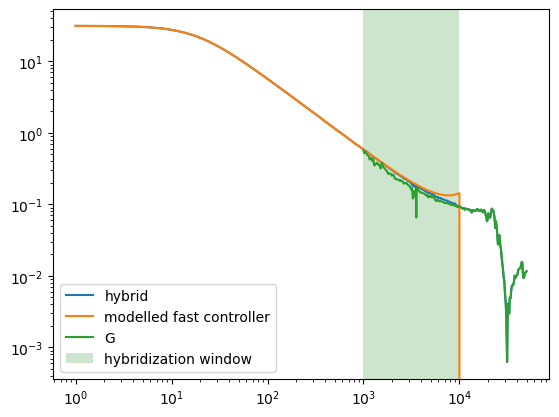

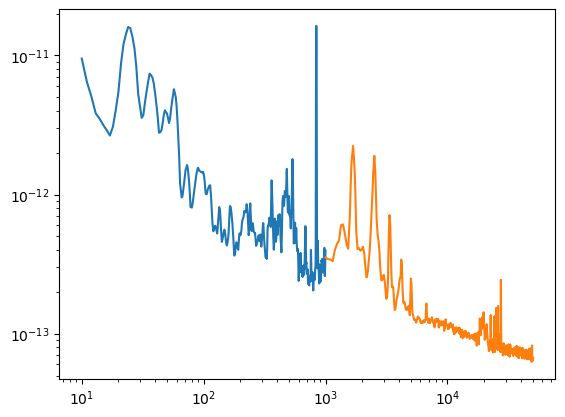

2.1066846753384624e-07


In [6]:
piezo_spec_low_freq_NOHV= moku_read_specB(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\piezoNOHVlock\piezoNOHVScan_lowfreq_20240422_113950_Traces.csv")
piezo_spec_high_freq_NOHV = moku_read_specB(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\piezoNOHVlock\piezoNOHVScan_highfreq_20240422_114050_Traces.csv")
piezo_scan_NOHV = moku_read_Probe_Points(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\piezoNOHVlock\piezoNOHV_scan_20240422_113628_Traces.csv")
G_piezo_NOHV = moku_read_TF_B(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\piezoNOHVlock\piezoNOHV_G_20240422_113851_Traces.csv")

scan_amp_piezo_NOHV = .386
scan_freq_piezo_NOHV = 10
order_piezo_NOHV = 1
ugf_piezo_NOHV = 5968
pass_band_db_piezo_NOHV = 53.2 #- 25.
prop_piezo_NOHV = 3.0 #-25.

NOHV_piezo_lowfreq,NOHV_piezo_cal_low,NOHV_piezo_highfreq,NOHV_piezo_cal_high,hybrid_freqs_NOHV,G_complex_hybrid_NOHV,CLGless_piezoNOHV_low,CLGless_piezoNOHV_high,cal = calibrate_piezo(prop_piezo_NOHV,ugf_piezo_NOHV,pass_band_db_piezo_NOHV,piezo_scan_NOHV,scan_amp_piezo_NOHV,scan_freq_piezo_NOHV,piezo_spec_low_freq_NOHV,piezo_spec_high_freq_NOHV,G_piezo_NOHV,HV=False)
plt.figure(3)
plt.loglog(NOHV_piezo_lowfreq,NOHV_piezo_cal_low)
plt.loglog(NOHV_piezo_highfreq,NOHV_piezo_cal_high)
plt.show()
print(cal)

Cutoff Frequency for Fast Controller: 25.21340202432466
FWHM 0.0003772112520619797
BW is: 127483.99473038263
Finesse is: 980.5152424377973


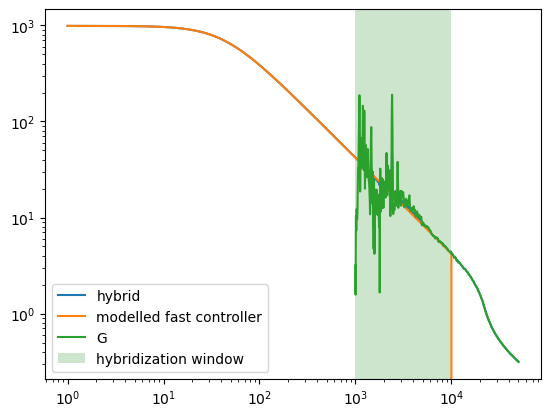

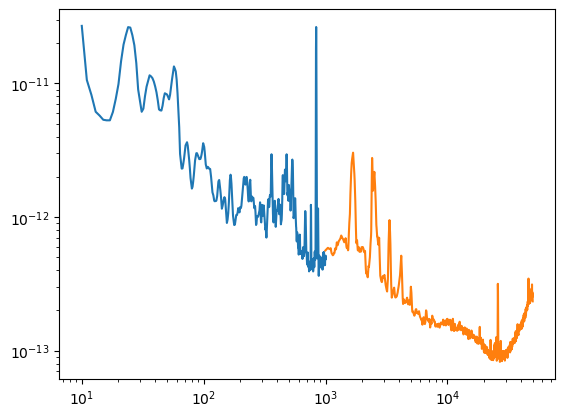

4.084758487485128e-07


In [7]:
laser_spec_low_freq = moku_read_specB(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\laserlock\laserSpec_lowfreq_20240422_111718_Traces.csv")
laser_spec_high_freq = moku_read_specB(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\laserlock\laserSpec_highfreq_20240422_111832_Traces.csv")
laser_scan = moku_read_Probe_Points(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\laserlock\laserscan_20240422_111421_Traces.csv")
G_laser = moku_read_TF_B(nextcloud_path+r"\Nextcloud\GQuEST\B102\Output Filter Cavity\FilterCavityScansAndTFs\Monday-4-22\laserlock\laserG_20240422_111634_Traces.csv")
scan_amp_laser = .335
scan_freq_laser = 10
order_laser = 1
ugf_laser = 24950.
pass_band_db_laser = 59.9


laser_lowfreq,laser_cal_low,laser_highfreq,laser_cal_high,hybrid_freqs_laser,G_complex_hybrid_laser,CLGless_laser_low,CLGless_laser_high,cal = calibrate_laser(order_laser,ugf_laser,pass_band_db_laser,laser_scan,scan_amp_laser,laser_spec_low_freq,laser_spec_high_freq,G_laser)
plt.figure(3)
plt.loglog(laser_lowfreq,laser_cal_low)
plt.loglog(laser_highfreq,laser_cal_high)
plt.show()
print(cal)

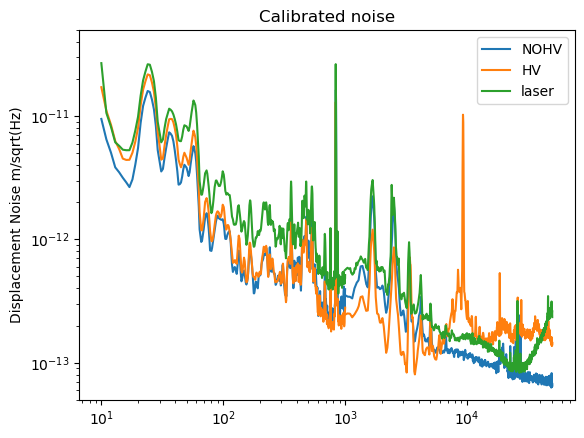

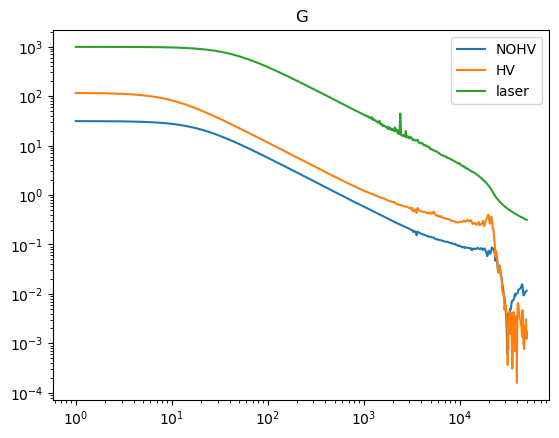

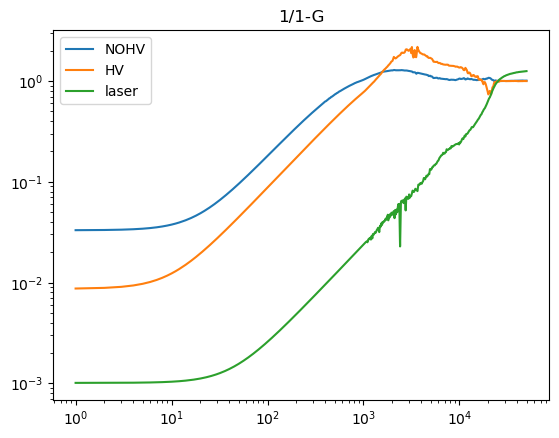

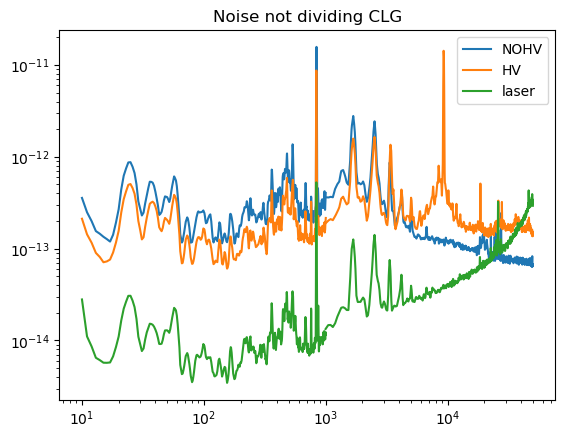

In [8]:
plt.loglog(NOHV_piezo_lowfreq,NOHV_piezo_cal_low,'C0',label = 'NOHV')
plt.loglog(NOHV_piezo_highfreq,NOHV_piezo_cal_high,'C0')
plt.loglog(HV_piezo_lowfreq,HV_piezo_cal_low,'C1',label = 'HV')
plt.loglog(HV_piezo_highfreq,HV_piezo_cal_high,'C1')
plt.loglog(laser_lowfreq,laser_cal_low,'C2', label = 'laser')
plt.loglog(laser_highfreq,laser_cal_high,'C2')
plt.ylim(5e-14,5e-11)
plt.title('Calibrated noise')
plt.ylabel('Displacement Noise m/sqrt(Hz)')
plt.legend()
plt.figure(2)
plt.title('G')
plt.loglog(hybrid_freqs_NOHV,np.abs(G_complex_hybrid_NOHV),label = 'NOHV')
plt.loglog(hybrid_freqs_HV,np.abs(G_complex_hybrid_HV),label = 'HV')
plt.loglog(hybrid_freqs_laser,np.abs(G_complex_hybrid_laser),label = 'laser')
plt.legend()
plt.figure(3)
plt.title('1/1-G')
plt.loglog(hybrid_freqs_NOHV,np.abs(1/(1-G_complex_hybrid_NOHV)),label = 'NOHV')
plt.loglog(hybrid_freqs_HV,np.abs(1/(1-G_complex_hybrid_HV)),label = 'HV')
plt.loglog(hybrid_freqs_laser,np.abs(1/(1-G_complex_hybrid_laser)),label = 'laser')
plt.legend()
plt.figure(4)
plt.title('Noise not dividing CLG')
plt.loglog(NOHV_piezo_lowfreq,CLGless_piezoNOHV_low,'C0',label = 'NOHV')
plt.loglog(NOHV_piezo_highfreq,CLGless_piezoNOHV_high,'C0')
plt.loglog(HV_piezo_lowfreq,CLGless_piezoHV_low,'C1',label = 'HV')
plt.loglog(HV_piezo_highfreq,CLGless_piezoHV_high,'C1')
plt.loglog(laser_lowfreq,CLGless_laser_low,'C2', label = 'laser')
plt.loglog(laser_highfreq,CLGless_laser_high,'C2')
plt.legend()
plt.show()
